###### Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
%matplotlib notebook

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        
def xticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
        
def yticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str("{0:.1f}".format(x)) if x < 0 else str("{0:.2f}".format(x))
    return label

In [2]:
#sample initial conditions
Toi = 1.0
Tai = 1.0

# model parameters, variables and functions
tune = 0.10           #model tuning parameter
Coo = -1.08 * tune
Coa = +1.00 * tune
Cao = +0.10 * tune
Caa = -1.12 * tune
m = 10.0

# define forcing function (weiner process with <cross-section>)
scale = 0.00          #relative amplitude of stochastic forcing
crosssec = scale * Tai
#crosssec = 0.0

# time series
ini = 500             #initialisation
t_start = 0.0
t_end = 500.0 + ini
time_samples = 500 + ini
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = ini/(t_end - t_start)     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [3]:
import sdeint

# set white noise forcing amplitude
W = np.diag([0.0, crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

In [4]:
#solve the system of ODEs with a sample set of initial conditions
samples = 10
rand.seed(546)     #to fix initial conditions
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

#calculate trajectories for all samples
VecCorr = []; LagCorr = []
for i in range(samples):
    #x0 = [rand.uniform(-Toi_lim, Toi_lim), rand.uniform(-Tai_lim, Tai_lim)]
    x0 = [Toi, Tai]
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    VecCorr.append(crosscor); LagCorr.append(lag_time)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))
    

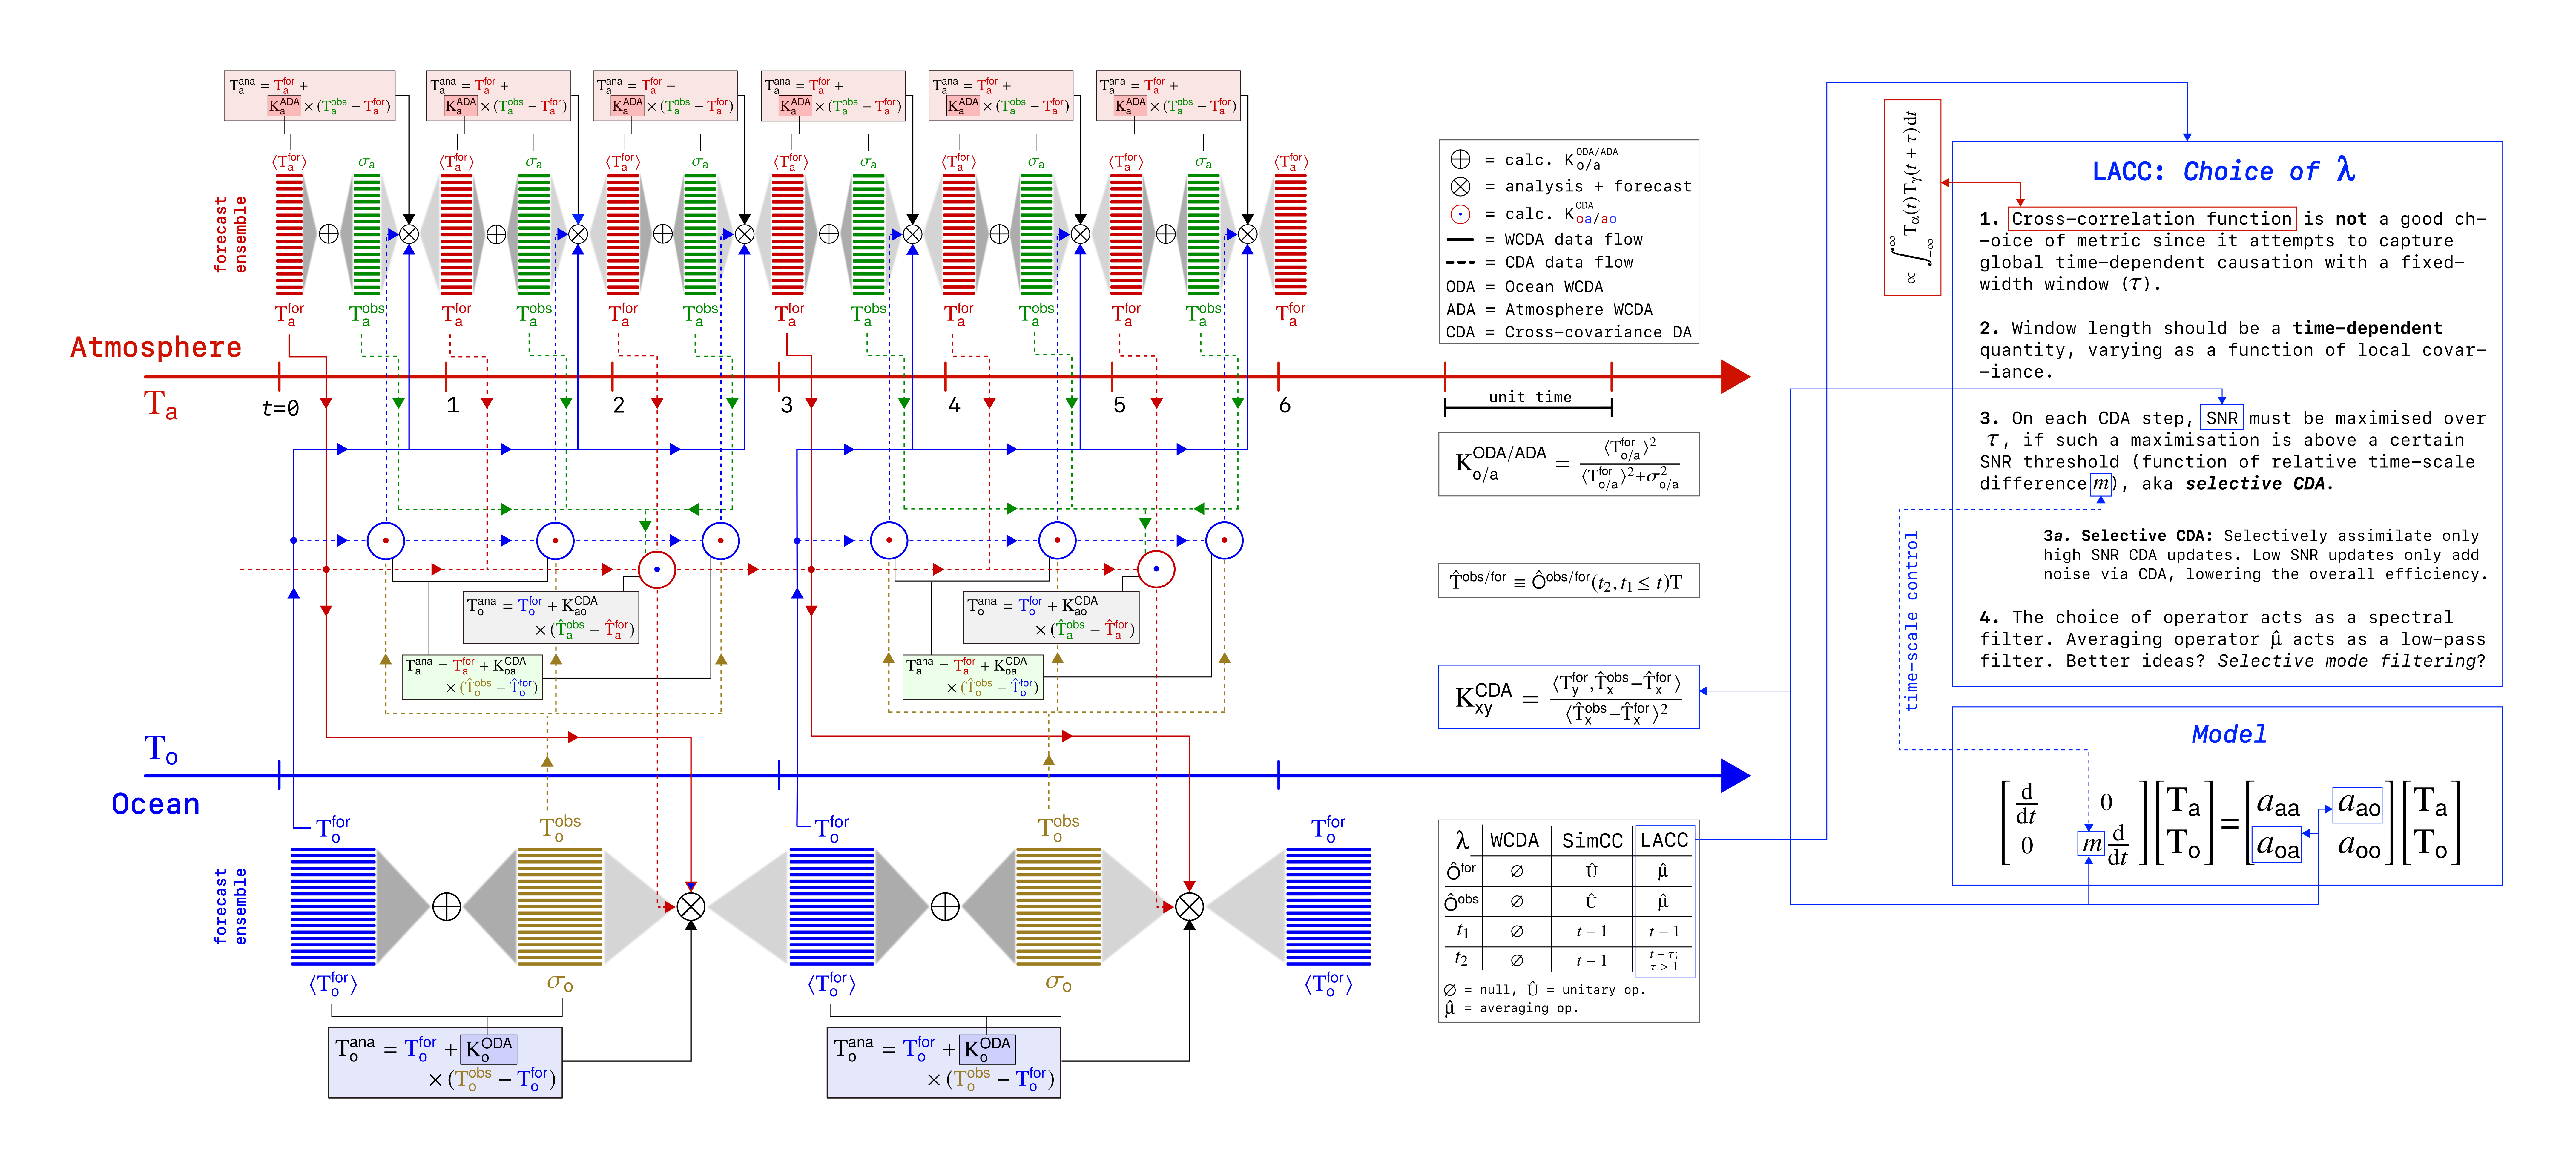

In [5]:
from IPython.display import Image
Image(filename=pwd + '/Liu15.png') 

# Simultaneous cross-correlation (SimCC)

Considering SimCC method, the cross update Kalman gain is written as

$$\mathsf{K} = \frac{\langle\mathsf{T}^f_\mathsf{O}(t)\,{\mathsf{T}^f_\mathsf{A}(t)}\rangle}{\langle{\mathsf{T}^f_\mathsf{A}(t)}\rangle + \sigma_{\mathsf{A},\mathsf{o}}^2} \propto \langle\mathsf{T}^f_\mathsf{O}(t)\,{\mathsf{T}^f_\mathsf{A}(t)}\rangle$$

where, sub-script $\sigma_\mathit{o}$ represents variance in observations.

The analysis states are then written as

$$\mathsf{T}^a_\mathsf{O}(t) = \mathsf{T}^f_\mathsf{O}(t) + \mathsf{K}\,\big[\big\{\mathsf{T}^\mathsf{o}_\mathsf{A}(t) + \mathsf{N}(0,\sigma_{\mathsf{A},\mathsf{o}})\big\} - \mathsf{T}^f_\mathsf{A}(t)\big],$$

where the analysis step acts as the forecast for the subsequent iteration, carrying forward the effect on Kalman Gain.

# Fourier space: 

Taking the fourier transform of the coupled set of ODEs:


$$\displaystyle2\pi i\mathsf{m} f\,\hat{\mathsf{T}}_\mathsf{A}(f) = \mathrm{C}_\mathsf{AA}\hat{\mathsf{T}}_\mathsf{O}(f) + \mathrm{C}_\mathsf{OA}\hat{\mathsf{T}}_\mathsf{A}(f),$$

$$\displaystyle 2\pi i f\,\hat{\mathsf{T}}_\mathsf{A}(f) = \mathrm{C}_\mathsf{AO}\hat{\mathsf{T}}_\mathsf{O}(f) + \mathrm{C}_\mathsf{AA}\hat{\mathsf{T}}_\mathsf{A}(f) + \hat{\mathsf{F}}(f).$$

where, for white noise $\hat{\mathsf{F}}(f) = \gamma$ is a constant. Solving the set of equations in fourier space yields:

$$\hat{\mathsf{T}}_\mathsf{O}(f)=\gamma\frac{\mathrm{C}_\mathsf{OA}}{(2\pi i f - \mathrm{C}_\mathsf{AA})(2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}) - \mathrm{C}_\mathsf{OA}\mathrm{C}_\mathsf{AO}}$$

$$\hat{\mathsf{T}}_\mathsf{A}(f)=\gamma\frac{2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}}{(2\pi i f - \mathrm{C}_\mathsf{AA})(2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}) - \mathrm{C}_\mathsf{OA}\mathrm{C}_\mathsf{AO}}$$

Furthermore, equating 

$$|\hat{\mathsf{T}}_\mathsf{O}(f)|^2=|\hat{\mathsf{T}}_\mathsf{A}(f)|^2 \rightarrow 0$$
and
$$|\hat{\mathsf{T}}_\mathsf{O}(f)|^2=|\hat{\mathsf{T}}_\mathsf{A}(f)|^2 \rightarrow \infty$$

gives the singular points in the fourier space. In particular, the $\infty$ is interesting.

**Kalman Gain**

Similarly the fourier transform of the Kalman Gain expression

$$\mathsf{K} = \frac{\langle\mathsf{T_O}(t)\,\mathsf{T_A}(t)\rangle}{\langle\mathsf{T_A}(t)\rangle + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau}}$$

yields

$$\hat{\mathsf{K}}_\mathcal{C}(f) = \frac{\hat{\mathsf{T}}_\mathsf{O}(f)}{\bigg[ [\hat{\mathsf{T}}_\mathsf{A}(f)]^2 + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau} \bigg]} \hat{\mathsf{T}}_\mathsf{A}(f)$$




In [6]:
import warnings
warnings.filterwarnings("error")

#set DA variables for SimCC simulation
atm_dev = 0.050       #assumed standard deviation in atmospheric observations
oce_dev = 0.020       #assumed standard deviation in oceanic observations
atm_syn = 0.050       #to generate atmospheric observation vector
oce_syn = 0.020       #to generate oceanic observation vector
win = 1              #SimCC   
Set = [1,1]          #[0,0] = None; [0,1] = A -> O; [1,0] = O -> A; [1,1] = Both 
NaN = np.float('nan')

def myround(x, base):
    return base * round(x/base)

def WCDA(ocean_v, atmos_v, t, win, item, atm_dev, oce_dev):
    oce_for_c = []; atm_for_c = []; oce_for = []; atm_for = []; oce_ana = []; atm_ana = []
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = [] 
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0
    oce_se = []; atm_se = []
    for num, time in enumerate(t):
        if num < ini:  #initialisation loop 
            if num > 0:#offset
                sol   = sdeint.itoint(unforc,forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                oce_ana.append(sol[1,0]); atm_ana.append(sol[1,1])
            else:
                oce_for.append(Toi); atm_for.append(Tai)
                oce_ana.append(Toi); atm_ana.append(Tai)
            oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
            atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
            flag = 'None'
        else:          #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1: 
                sol   = sdeint.itoint(unforc,forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                try:
                    covar_matrix   = np.cov(np.array([oce_for,atm_for]))
                    var_atm   =   covar_matrix[1][1]
                    var_oce   =   covar_matrix[0][0]
                    flag = 'lowered WCDA'
                except RuntimeWarning:
                    var_atm   = 0.0; var_oce   = 0.0
                    flag = 'raised WCDA' 
                Ka = ((var_atm))/((var_atm) + (atm_dev)**2)
                Ko = ((var_oce))/((var_oce) + (oce_dev)**2)
                oce_gain   = Ko * (oce_obs[num] - oce_for[-1])
                atm_gain   = Ka * (atm_obs[num] - atm_for[-1])
                KalGainO.append(Ko); KalGainA.append(Ka)
                ocean = oce_for[-1] + oce_gain
                atmos = atm_for[-1] + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
            else:
                None
    return KalGainO, KalGainA, oce_for, atm_for, oce_se, atm_se, oce_ana, atm_ana

def SCDA(ocean_v, atmos_v, t, win, item, atm_dev, oce_dev):
    oce_for_c = []; atm_for_c = []; oce_for = []; atm_for = []; oce_ana = []; atm_ana = []
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = []; KalGainD =[]
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0
    oce_se = []; atm_se = []
    for num, time in enumerate(t):
        if num < ini:  #initialisation loop 
            if num > 0:#offset
                sol   = sdeint.itoint(unforc,forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                oce_ana.append(sol[1,0]); atm_ana.append(sol[1,1])
            else:
                oce_for.append(Toi); atm_for.append(Tai)
                oce_ana.append(Toi); atm_ana.append(Tai)
            oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
            atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
            flag = 'None'
        else:          #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1: 
                sol   = sdeint.itoint(unforc,forc,[oce_ana[-1],atm_ana[-1]],[0,1])
                oce_for.append(sol[1,0]); atm_for.append(sol[1,1])
                try:
                    covar_matrix   = np.cov(np.array([oce_for,atm_for]))
                    det       =   np.linalg.det(covar_matrix)
                    covar     =   covar_matrix[0][1]
                    var_atm   =   covar_matrix[1][1]
                    var_oce   =   covar_matrix[0][0]
                    flag = 'lowered CDA'
                except RuntimeWarning:
                    covar     = 0.0; var_atm   = 0.0; var_oce   = 0.0
                    flag = 'raised CDA' 
                D  = (((var_oce) + (oce_dev)**2)*((var_atm) + (atm_dev)**2) - (covar**2))  
                Kc = (covar*((oce_dev)**2))/D
                Kd = (covar*((atm_dev)**2))/D
                Ka = ((var_atm)*(var_oce + (oce_dev)**2) - (covar**2))/D
                Ko = ((var_oce)*(var_atm + (atm_dev)**2) - (covar**2))/D
                if Set[0] == 0 and Set[-1] == 0:
                    atm_gain_c = 0.0
                    oce_gain_c = 0.0
                elif Set[0] == 0 and Set[-1] == 1:
                    oce_gain_c = Kc * (atm_obs[num] - atm_for[-1])
                    atm_gain_c = 0.0
                elif Set[0] == 1 and Set[-1] == 0:
                    oce_gain_c = 0.0
                    atm_gain_c = Kd * (oce_obs[num] - oce_for[-1])
                elif Set[0] == 1 and Set[-1] == 1:
                    oce_gain_c = Kc * (atm_obs[num] - atm_for[-1])
                    atm_gain_c = Kd * (oce_obs[num] - oce_for[-1])
                else:
                    error('Illegal Input')
                oce_gain   = Ko * (oce_obs[num] - oce_for[-1])
                atm_gain   = Ka * (atm_obs[num] - atm_for[-1])
                KalGainD.append(Kd); KalGainC.append(Kc); KalGainO.append(Ko); KalGainA.append(Ka)
                ocean = oce_for[-1] + oce_gain_c + oce_gain
                atmos = atm_for[-1] + atm_gain_c + atm_gain
                oce_ana.append(ocean); atm_ana.append(atmos)
                oce_se.append(np.abs(oce_ana[-1] - oce_obs[num])**2)
                atm_se.append(np.abs(atm_ana[-1] - atm_obs[num])**2)
            else:
                None
    return KalGainD, KalGainC, KalGainO, KalGainA, oce_for, atm_for, oce_se, atm_se, oce_ana, atm_ana

KalDecMat = []; KalDecMax = []; KalDecMaxVal = []
KalCovMat = []; KalCovMax = []; KalCovMaxVal = []
KalAMat   = [];   KalAMax = [];   KalAMaxVal = []
KalOMat   = [];   KalOMax = [];   KalOMaxVal = []
atm_obs   = [];   oce_obs = []; atm_obs_mean = []
atm_mse   = [];   oce_mse = []
atm_mseW  = [];  oce_mseW = []
oce_for_save  = []; atm_for_save  = []
oce_for_saveW = []; atm_for_saveW = []
oce_ana_save  = []; atm_ana_save  = []
oce_ana_saveW = []; atm_ana_saveW = []

np.random.seed(int(m))
randsamp = np.random.randint(0,samples)
atm_obs = [val + noi for val, noi in zip(Ta_l[randsamp], np.random.normal(0.0, atm_syn, len(t)))]     #atmos obs vector
oce_obs = [val + noi for val, noi in zip(To_l[randsamp], np.random.normal(0.0, oce_syn, len(t)))]     #ocean obs vector

for i in range(samples):
    To_t = To_l[i][:ini]   
    Ta_t = Ta_l[i][:ini] 
    KalCovDec, KalCovVec, KalOVec, KalAVec, oce_for, atm_for, oce_se, atm_se, oce_ana, atm_ana  = SCDA(To_t, Ta_t, t, win, i, atm_dev, oce_dev)
    KalOVecW, KalAVecW, oce_forW, atm_forW, oce_seW, atm_seW, oce_anaW, atm_anaW     = WCDA(To_t, Ta_t, t, win, i, atm_dev, oce_dev) 
                                                                           #passing win=1 ensures SimCC method
    time_ignore = int(np.floor(time_stable*len(KalCovVec)))                #ignore fraction of preceding analysis 
    #KalCovVec[:time_ignore] = []; KalAVec[:time_ignore] = []; KalOVec[:time_ignore] = []
    KalDecMat.append(KalCovDec); KalCovMat.append(KalCovVec); KalAMat.append(KalAVec); KalOMat.append(KalOVec)
    KalDecMax.append(np.argmax((KalCovDec))); KalCovMax.append(np.argmax((KalCovVec))); KalAMax.append(np.argmax((KalAVec))); KalOMax.append(np.argmax((KalOVec)))
    KalDecMaxVal.append(np.max((KalCovDec))); KalCovMaxVal.append(np.max((KalCovVec))); KalAMaxVal.append(np.max((KalAVec))); KalOMaxVal.append(np.max((KalOVec)))   
    oce_for_save.append(oce_for);   atm_for_save.append(atm_for)
    oce_for_saveW.append(oce_forW); atm_for_saveW.append(atm_forW)
    oce_ana_save.append(oce_ana);   atm_ana_save.append(atm_ana)
    oce_ana_saveW.append(oce_anaW); atm_ana_saveW.append(atm_anaW)   
    oce_mse.append(oce_se);   atm_mse.append(atm_se) 
    oce_mseW.append(oce_seW); atm_mseW.append(atm_seW)
    
KalCovMatRaw = KalCovMat
KalDecMatRaw = KalDecMat
time_stab    = t[time_ignore:]
oce_rmse     = np.sqrt(np.mean(oce_mse,  axis=0))
atm_rmse     = np.sqrt(np.mean(atm_mse,  axis=0))
oce_rmseW    = np.sqrt(np.mean(oce_mseW, axis=0))
atm_rmseW    = np.sqrt(np.mean(atm_mseW, axis=0))

lengths_d = []; power2_d = []
for row in KalDecMat:
    lengths_d.append(len(row))
    power2_d.append(np.sum(row)/len(row))
lengths_c = []; power2_c = []
for row in KalCovMat:
    lengths_c.append(len(row))
    power2_c.append(np.sum(row)/len(row))
lengths_o = []; power2_o = []
for row in KalOMat:
    lengths_o.append(len(row))
    power2_o.append(np.sum(row)/len(row))
lengths_a = []; power2_a = []
for row in KalAMat:
    lengths_a.append(len(row))
    power2_a.append(np.sum(row)/len(row))

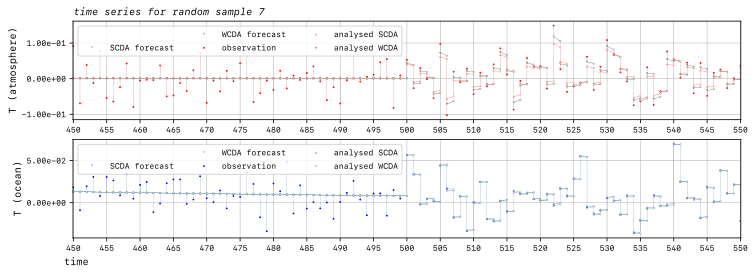

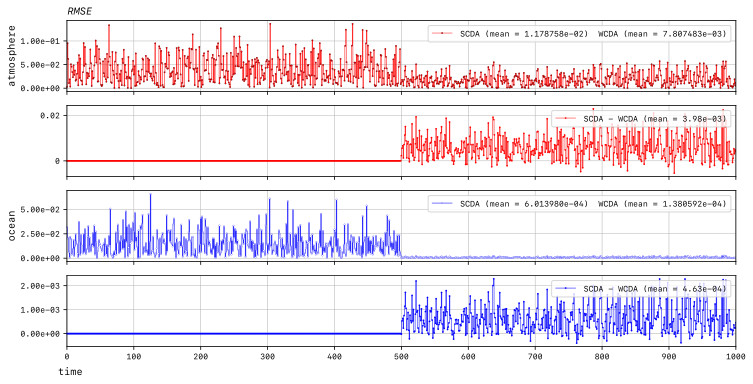

In [9]:
# plot sample time series and RMSE
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'

randsamp = np.random.randint(0,samples)
time_plot = [450, 550]
#time_plot = [int(t[0]), int(t[-1])]
stepping  = (time_plot[-1] - time_plot[0])/20

#plot a sample trajectory
fig = plt.figure(figsize=(12,4), dpi=200);
#--Atmopshere
plt.subplot(2, 1, 1)
t_s = t[time_plot[0]:time_plot[-1] + 1]; y1 = atm_ana_save[randsamp][time_plot[0]:time_plot[-1] + 1] 
y2 = atm_for_save[randsamp][time_plot[0]:time_plot[-1] + 1]; y3 = atm_obs[time_plot[0]:time_plot[-1] + 1]
y4 = Ta_l[randsamp][time_plot[0]:time_plot[-1] + 1]; y5 = atm_for_saveW[randsamp][time_plot[0]:time_plot[-1] + 1]
y7 = atm_ana_saveW[randsamp][time_plot[0]:time_plot[-1] + 1] 
plt.plot(   t_s, y4, '--r', linewidth=0.5, alpha = 0.0, drawstyle='steps-post', marker='.', markersize=0.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
plt.scatter(t_s, y3, marker='.', s=3, c='r', alpha = 1.0);
plt.scatter(t_s, y1, marker='^', s=3, edgecolor='r', alpha = 1.0, facecolor='w', linewidth=0.2);
plt.scatter(t_s, y7, marker='v', s=3, edgecolor='k', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.step(   t_s, y2,  'r', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='r', markeredgewidth=0.2);
plt.step(   t_s, y5,  'k', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
for i in range(0, len(t_s)):
    plt.plot([t_s[i], t_s[i]], [min(y7[i],y5[i],y3[i]), max(y7[i],y5[i],y3[i])], '--k', linewidth=0.1, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i]], [min(y1[i],y2[i],y3[i]), max(y1[i],y2[i],y3[i])], '--r', linewidth=0.1, zorder=0, label='_nolegend_')
for i in range(0, len(t_s) - 1):
    plt.plot([t_s[i], t_s[i + 1]], [y7[i], y5[i + 1]], '-k', linewidth=0.2, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i + 1]], [y1[i], y2[i + 1]], '-r', linewidth=0.2, zorder=0, label='_nolegend_')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('T (atmosphere)' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['', 'SCDA forecast','WCDA forecast','observation','analysed SCDA', 'analysed WCDA'], loc='best', ncol=3)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax.set_title('time series for random sample ' + str(randsamp), fontproperties=fontit,fontsize=10, y=1.00, loc='left');
#--Ocean
plt.subplot(2, 1, 2)
t_s = t[time_plot[0]:time_plot[-1] + 1]; y1 = oce_ana_save[randsamp][time_plot[0]:time_plot[-1] + 1] 
y2 = oce_for_save[randsamp][time_plot[0]:time_plot[-1] + 1]; y3 = oce_obs[time_plot[0]:time_plot[-1] + 1]
y4 = To_l[randsamp][time_plot[0]:time_plot[-1] + 1]; y5 = oce_for_saveW[randsamp][time_plot[0]:time_plot[-1] + 1]
y7 = oce_ana_saveW[randsamp][time_plot[0]:time_plot[-1] + 1] 
plt.plot(   t_s, y4, '--b', linewidth=0.5, alpha = 0.0, drawstyle='steps-post', marker='.', markersize=0.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
plt.scatter(t_s, y3, marker='.', s=3, c='b', alpha = 1.0);
plt.scatter(t_s, y1, marker='^', s=3, edgecolor='b', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.scatter(t_s, y7, marker='v', s=3, edgecolor='g', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.step(   t_s, y2,  'b', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='b', markeredgewidth=0.2);
plt.step(   t_s, y5,  'g', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='g', markeredgewidth=0.2);
for i in range(0, len(t_s)):
    plt.plot([t_s[i], t_s[i]], [min(y7[i],y5[i],y3[i]), max(y7[i],y5[i],y3[i])], '--g', linewidth=0.1, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i]], [min(y1[i],y2[i],y3[i]), max(y1[i],y2[i],y3[i])], '--b', linewidth=0.1, zorder=1, label='_nolegend_')
for i in range(0, len(t_s) - 1):
    plt.plot([t_s[i], t_s[i + 1]], [y7[i], y5[i + 1]], '-g', linewidth=0.2, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i + 1]], [y1[i], y2[i + 1]], '-b', linewidth=0.2, zorder=1, label='_nolegend_')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.xlabel('time'      ,fontproperties=font,fontsize=10);
plt.ylabel('T (ocean)' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.2)
l1 = ax.legend(['', 'SCDA forecast','WCDA forecast','observation','analysed SCDA', 'analysed WCDA'], loc='best', ncol=3)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

#plot RMSE
time_plot = [int(t[0]), int(t[-1])]
#time_plot = [50, 150]
stepping  = (time_plot[-1] - time_plot[0])/10
half      = int(round(time_plot[-1] - time_plot[0]/2))
fig = plt.figure(figsize=(12,6), dpi=200);
#--Atmopshere
plt.subplot(4, 1, 1)
mean  = np.mean(atm_rmse[half:time_plot[-1] + 1])
meanW = np.mean(atm_rmseW[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], atm_rmse[time_plot[0]:time_plot[-1] + 1],  'r', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='r', markeredgecolor='k', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('atmosphere' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA (mean = ' + str("{:.6e}".format(mean)) + ')  ' + 'WCDA (mean = ' + str("{:.6e}".format(meanW)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax.set_title('RMSE', fontproperties=fontit,fontsize=10, y=1.00, loc='left');
plt.setp(ax.get_xticklabels(), visible=False)

diff_atm_rmse = [(i - j) for i,j in zip(atm_rmse, atm_rmseW)]
plt.subplot(4, 1, 2)
mean  = np.mean(diff_atm_rmse[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], diff_atm_rmse[time_plot[0]:time_plot[-1] + 1],  'r', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='r', markeredgecolor='r', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA - WCDA (mean = ' + str("{:.2e}".format(mean)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.setp(ax.get_xticklabels(), visible=False)

#--Ocean
plt.subplot(4, 1, 3)
mean  = np.mean(oce_rmse[half:time_plot[-1] + 1])
meanW = np.mean(oce_rmseW[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], oce_rmse[time_plot[0]:time_plot[-1] + 1],  'b', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='b', markeredgewidth=0.2);
plt.step(t[time_plot[0]:time_plot[-1] + 1], oce_rmseW[time_plot[0]:time_plot[-1] + 1], 'g', linewidth=0.5, alpha = 0.0, where='mid', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='g', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('ocean' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA (mean = ' + str("{:.6e}".format(mean)) + ')  ' + 'WCDA (mean = ' + str("{:.6e}".format(meanW)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.setp(ax.get_xticklabels(), visible=False)


diff_oce_rmse = [(i - j) for i,j in zip(oce_rmse, oce_rmseW)]
mean = np.mean(diff_oce_rmse[half:time_plot[-1] + 1])
plt.subplot(4, 1, 4)
plt.step(t[time_plot[0]:time_plot[-1] + 1], diff_oce_rmse[time_plot[0]:time_plot[-1] + 1],  'b', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='b', markeredgecolor='b', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA - WCDA (mean = ' + str("{:.2e}".format(mean)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
plt.xlabel('time'      ,fontproperties=font,fontsize=10); ax.xaxis.set_label_coords(0.005, -0.3)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

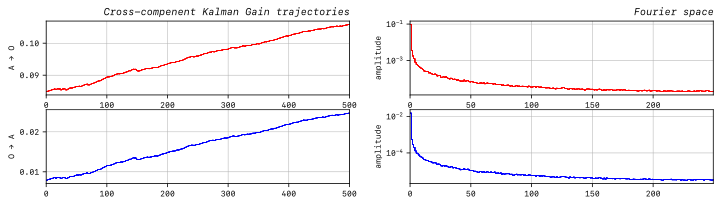

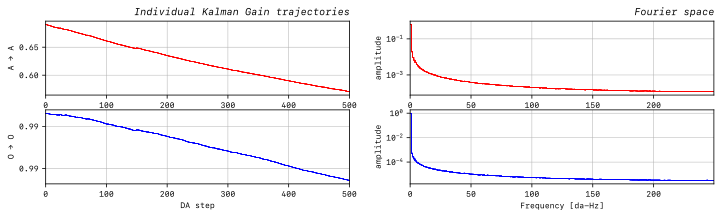

In [8]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from matplotlib.colors import LogNorm
import unicodedata

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

def stretch_to(l, n, insert):
    Out = [insert] * n
    m = len(l)
    if m == 1:
        m = 2
    for i, x in enumerate(l):
        Out[i * (n - 1) // (m - 1)] = x
    return Out

NaN = float('nan')

if 0 == 1:
    #stretched list
    KalCovLong = []
    for row in KalCovMatRaw:
        row_long = stretch_to(row, renorm, NaN)
        row_new = fill_nan(np.array(row_long))
        KalCovLong.append(row_new)

    #make rows equal lengths for plotting
    maxLen = max(map(len, KalCovMat))
    for row in KalCovMat:
        if len(row) < maxLen:
            row.extend(NaN for _ in range(maxLen - len(row)))

    #draw trajectories of Cross-Corr
    fig, ax = plt.subplots(figsize=(40,40), dpi=200);
    #PlotMat = np.array(KalCovMat).transpose()
    PlotMat = np.array(KalCovMat)
    im = ax.matshow(PlotMat,origin='lower');
    ax.grid(which='minor')
    ax.set_aspect(1.0)

    #colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="3%", pad = 0.1)
    cb = plt.colorbar(im, cax=cax,label='Kalman Gain',orientation="horizontal");
    axc = cb.ax
    text = axc.xaxis.label
    text.set_font_properties(proplr)
    ticks(axc,10);

    ax.set_xlabel('DA step',fontproperties=font,fontsize=12); 
    ax.xaxis.set_label_position('top');
    ax.set_ylabel('sample number',fontproperties=font,fontsize=12); 

    ticks(ax,10);
    ax.set_title('Kalman Gain trajectories',fontproperties=fontit,fontsize=12, y=1.15, loc='left');

#--Cov
#Atmosphere to Ocean Cross-component
plt.figure(figsize=(12,3),dpi=200);
plt.subplot(2, 2, 3)
for row in KalCovMat:
    plt.plot(row, c='b', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('O ' + u"\u2192" + ' A',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#frequency space
FFT = []; FQ = []
for row in KalCovMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(2, 2, 4)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='b', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_yscale('log')

#Ocean to Atmosphere Cross-component
plt.subplot(2, 2, 1)
for row in KalDecMat:
    plt.plot(row, c='r', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('A ' + u"\u2192" + ' O',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Cross-compenent Kalman Gain trajectories',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#frequency space
FFT = []; FQ = []
for row in KalDecMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(2, 2, 2)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='r', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Fourier space',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.set_yscale('log')

plt.figure(figsize=(12,3),dpi=200);
#--Atmosphere
plt.subplot(2, 2, 1)
for row in KalAMat:
    plt.plot(row, c='red', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('A ' + u"\u2192" + ' A',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Individual Kalman Gain trajectories',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
#frequency space
FFT = []; FQ = []
for row in KalAMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(2, 2, 2)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='r', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Fourier space',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.set_yscale('log')

#--Ocean
plt.subplot(2, 2, 3)
for row in KalOMat:
    plt.plot(row, c='b', linewidth=0.5, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.xlabel('DA step',fontproperties=font,fontsize=8);
plt.ylabel('O ' + u"\u2192" + ' O',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#frequency space
FFT = []; FQ = []
for row in KalOMat:
    ts= len(row)
    F = np.fft.fft(row)
    FFT.append(np.abs(F)[:ts // 2] * 1 / ts)
Q  = np.linspace(0, ts, ts)
FQ.append(Q[:ts // 2])
plt.subplot(2, 2, 4)
for row in FFT:
    plt.plot(np.array(FQ).transpose(), row, c='b', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.xlabel('Frequency [da-Hz]',fontproperties=font,fontsize=8);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_yscale('log')


We test the total power per run by integrating the Kalman Gain over time for each sample. 

# Summary of variable values

## Model:

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}^{(10.0)}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix}\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix} = \begin{bmatrix}
    \mathrm{C}_\mathsf{OO}^{\,(-0.108)} & \mathrm{C}_\mathsf{OA}^{\,(+0.100)} \\
    \mathrm{C}_\mathsf{AO}^{\,(+0.010)} & \mathrm{C}_\mathsf{AA}^{\,(-0.112)}  
\end{bmatrix}\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix} + \begin{bmatrix}
    \emptyset \\
    \mathsf{F}^{\{\mathcal{G}\,=\,0.00\}}(t) 
\end{bmatrix}$$ 

## Initial Conditions:

$$\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}_{(t\,=\,0)} = \begin{bmatrix}
    1.0 \\
    1.0 
\end{bmatrix}$$

## Observational Variances

$$\begin{bmatrix}
    \sigma_{\mathsf{O},o} \\
    \sigma_{\mathsf{A},o} 
\end{bmatrix} = \begin{bmatrix}
    0.02 \\
    0.05 
\end{bmatrix}$$

## Duration:

Total duration: 5000 steps

Initialisation:  100 steps

